In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
        print(os.path.join(dirname))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/microsoft-catsvsdogs-dataset
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat
/kaggle/input/config2


In [2]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import yaml


# folder to load config file
CONFIG_PATH = "/kaggle/input/config2"

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config


config = load_config("model.yml")
config

{'model': {'name': 'SimpleCNN',
  'type': 'classification',
  'architecture': {'layers': [{'type': 'Conv2d',
     'in_channels': 3,
     'out_channels': 8,
     'kernel_size': '(3, 3)',
     'stride': 1,
     'padding': 1},
    {'type': 'BatchNorm2d', 'num_features': 8},
    {'type': 'ReLU'},
    {'type': 'MaxPool2d', 'kernel_size': '(2, 2)', 'stride': 2},
    {'type': 'Conv2d',
     'in_channels': 8,
     'out_channels': 16,
     'kernel_size': '(3, 3)',
     'stride': 1,
     'padding': 1},
    {'type': 'BatchNorm2d', 'num_features': 16},
    {'type': 'ReLU'},
    {'type': 'MaxPool2d', 'kernel_size': '(2, 2)', 'stride': 2},
    {'type': 'Conv2d',
     'in_channels': 16,
     'out_channels': 32,
     'kernel_size': '(3, 3)',
     'stride': 1,
     'padding': 1},
    {'type': 'BatchNorm2d', 'num_features': 32},
    {'type': 'ReLU'},
    {'type': 'MaxPool2d', 'kernel_size': '(2, 2)', 'stride': 2},
    {'type': 'Flatten'},
    {'type': 'Linear', 'in_features': 25088, 'out_features': 32},

{'Cat': 12501, 'Dog': 12501}


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


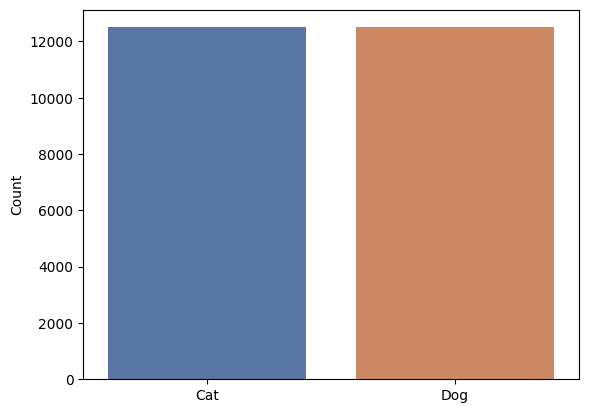

In [3]:
root_directory = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'
cls_name=['Cat','Dog' ]
data = {n: len(os.listdir(os.path.join(root_directory, n))) for n in cls_name}
print(data)

sns.barplot(x=list(data.keys()), y=list(data.values()),palette="deep")
plt.ylabel('Count')
plt.show()

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the dataset
dataset = datasets.ImageFolder(root_directory, transform=transform)

# Filter out images you want to exclude
filtered_indices = []
def meets_criteria(img_path):
    files_to_exclude = ['666.jpg','11702.jpg']
    
    # Get the base name of the image path (i.e., the file name)
    img_filename = os.path.basename(img_path) 
    # Check if the image filename is not in the list of files to exclude
    return img_filename not in files_to_exclude

for idx, (img_path, label) in enumerate(dataset.samples):
    # Example: Exclude images with specific conditions
    if meets_criteria(img_path):
        filtered_indices.append(idx)

# Exclude filtered indices from the dataset
filtered_dataset = torch.utils.data.Subset(dataset, indices=filtered_indices)

# Specify the split ratios
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Calculate the number of samples for each split
num_samples = len(filtered_dataset)
num_train = int(train_ratio * num_samples)
num_test = int(test_ratio * num_samples)
num_val = num_samples - num_train - num_test

# Use random_split to split the filtered dataset
train_data, test_val_data = random_split(filtered_dataset, [num_train, num_test + num_val])
test_data, val_data = random_split(test_val_data, [num_test, num_val])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

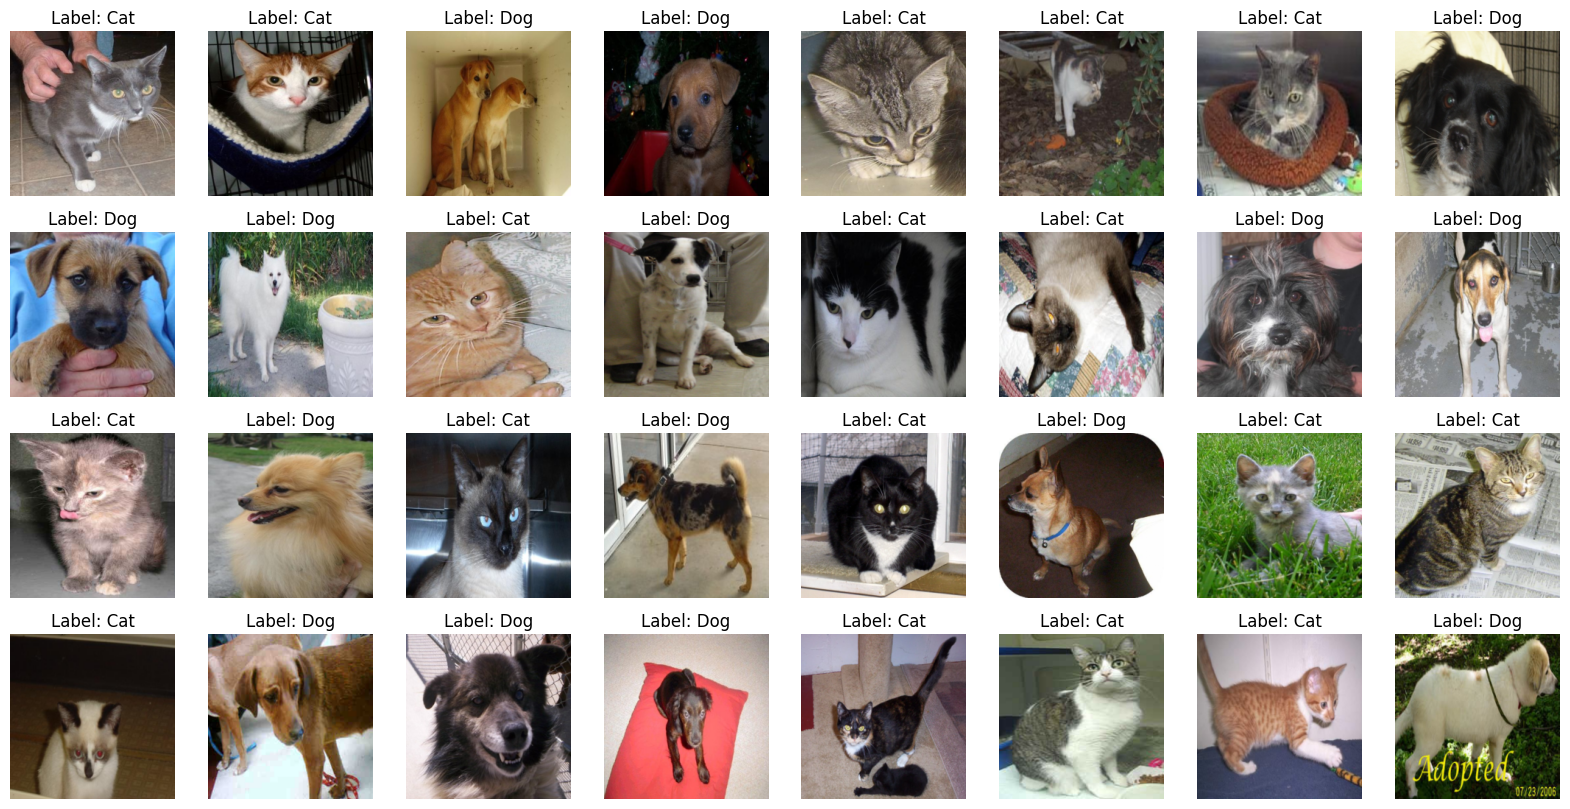

In [5]:
def show_images(images, labels):
    plt.figure(figsize=(20, 10))
    num_images = len(images)
    
    for i in range(num_images):
        plt.subplot(int(num_images/8),8, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f"Label: {cls_name[labels[i]]}")
        plt.axis('off')
    
    plt.show()

for batch, (X_train, y_train) in enumerate(train_loader):
    break

show_images(X_train, y_train)

In [6]:
X_train.shape, y_train.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
import torch.nn as nn
import torch.optim as optim

def build_model(config):
    model_config = config['model']
    model_name = model_config['name']
    
    if model_name == 'SimpleCNN':
        return build_simple_cnn(model_config)
    # Add other model types here as needed

def build_simple_cnn(model_config):
    layers_config = model_config['architecture']['layers']
    layers = []
    for layer_config in layers_config:
        layer_type = layer_config['type']
        if layer_type == 'Conv2d':
            layer = nn.Conv2d(layer_config['in_channels'], layer_config['out_channels'],
                              eval(layer_config['kernel_size']), stride=layer_config['stride'],
                              padding=layer_config['padding'])
        elif layer_type == 'ReLU':
            layer = nn.ReLU()
        elif layer_type == 'Tanh':
            layer = nn.Tanh()    
        elif layer_type == 'MaxPool2d':
            layer = nn.MaxPool2d(eval(layer_config['kernel_size']), stride=layer_config['stride'])
        elif layer_type == 'BatchNorm2d':
            layer = nn.BatchNorm2d(layer_config['num_features'])
        elif layer_type == 'Dropout':
            layer = nn.Dropout(p=layer_config['p'])    
        elif layer_type == 'Flatten':
            layer = nn.Flatten()
        elif layer_type == 'Linear':
            layer = nn.Linear(layer_config['in_features'], layer_config['out_features'])
        layers.append(layer)
    return nn.Sequential(*layers)

def get_loss_function(loss_function_name):
    if loss_function_name == 'CrossEntropyLoss':
        return nn.CrossEntropyLoss()
    # Add other loss functions here as needed

def get_optimizer(optimizer_config, model_parameters):
    optimizer_type = optimizer_config['type']
    if optimizer_type == 'RMSprop':
        return optim.RMSprop(model_parameters, lr=optimizer_config['learning_rate'],
                             weight_decay=optimizer_config['weight_decay'])
    # Add other optimizers here as needed


model = build_model(config).to(device)
loss_function = get_loss_function(config['model']['loss_function'])
optimizer = get_optimizer(config['model']['optimizer'], model.parameters())
# training_parameters = get_training_parameters(config['model']['training_parameters'])

In [9]:
model

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=25088, out_features=32, bias=True)
  (14): Tanh()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=32, out_features=32, bia

In [10]:
# model = model().to(device)
# criterion = nn.CrossEntropyLoss()
from torch.optim import lr_scheduler

optimizer = optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
num_epochs = 15
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total = 0

    # Initialize running loss as a tensor with zero value
    running_loss = torch.zeros(1, device=device, requires_grad=True)
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        _, predicted_train = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Update the running loss using the tensor addition with detached tensor
        running_loss = running_loss + loss

        loss.backward()
        optimizer.step()

    avg_loss = running_loss.item() / len(train_loader)
    train_losses.append(avg_loss)

    train_accuracy = correct_train / total
    train_accuracies.append(train_accuracy)
    scheduler.step()
    model.eval()
    correct_val = 0
    total_val = 0

    # Initialize validation running loss as a tensor with zero value
    val_running_loss = torch.zeros(1, device=device, requires_grad=False)

    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            outputs_val = model(inputs_val)
            val_loss = loss_function(outputs_val, labels_val)
            _, predicted_val = torch.max(outputs_val.data, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()
            
            # Update the validation running loss using the tensor addition with detached tensor
            val_running_loss = val_running_loss.detach() + val_loss

        val_avg_loss = val_running_loss.item() / len(val_loader)
        val_losses.append(val_avg_loss)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Validation Loss: {val_avg_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%')

Epoch [1/15], Train Loss: 0.6596, Validation Loss: 0.6278, Train Accuracy: 60.92%, Validation Accuracy: 65.79%
Epoch [2/15], Train Loss: 0.6327, Validation Loss: 0.6113, Train Accuracy: 65.03%, Validation Accuracy: 67.52%
Epoch [3/15], Train Loss: 0.6143, Validation Loss: 0.5966, Train Accuracy: 67.31%, Validation Accuracy: 69.28%
Epoch [4/15], Train Loss: 0.6002, Validation Loss: 0.5843, Train Accuracy: 69.39%, Validation Accuracy: 70.93%
Epoch [5/15], Train Loss: 0.5851, Validation Loss: 0.5704, Train Accuracy: 70.55%, Validation Accuracy: 71.65%
Epoch [6/15], Train Loss: 0.5692, Validation Loss: 0.5599, Train Accuracy: 72.45%, Validation Accuracy: 72.32%
Epoch [7/15], Train Loss: 0.5582, Validation Loss: 0.5510, Train Accuracy: 73.10%, Validation Accuracy: 72.93%
Epoch [8/15], Train Loss: 0.5405, Validation Loss: 0.5555, Train Accuracy: 74.68%, Validation Accuracy: 71.71%
Epoch [9/15], Train Loss: 0.5350, Validation Loss: 0.5414, Train Accuracy: 75.05%, Validation Accuracy: 73.39%
E

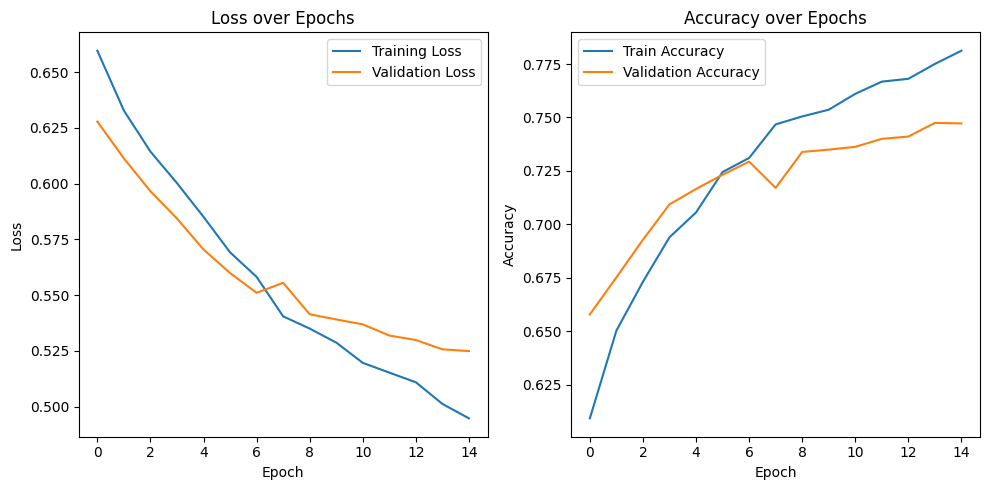

In [11]:
plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
model.eval()
correct_test = 0
total_test = 0
true_labels=[]
predict_label=[]
predicted_probas=[]
with torch.inference_mode():
    for inputs_test, labels_test in test_loader:
        true_labels.append(labels_test)
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = model(inputs_test)
        probas = nn.functional.softmax(outputs_test, dim=1)
        predicted_probas.append(probas)
        _, predicted_test = torch.max(probas.data, 1)
        predict_label.append(predicted_test)

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [13]:
true_labels = torch.cat(true_labels, dim=0)
predict_label= torch.cat(predict_label, dim=0)
predicted_probas= torch.cat(predicted_probas, dim=0)
predict_label=predict_label.to('cpu')
predicted_probas=predicted_probas.to('cpu')

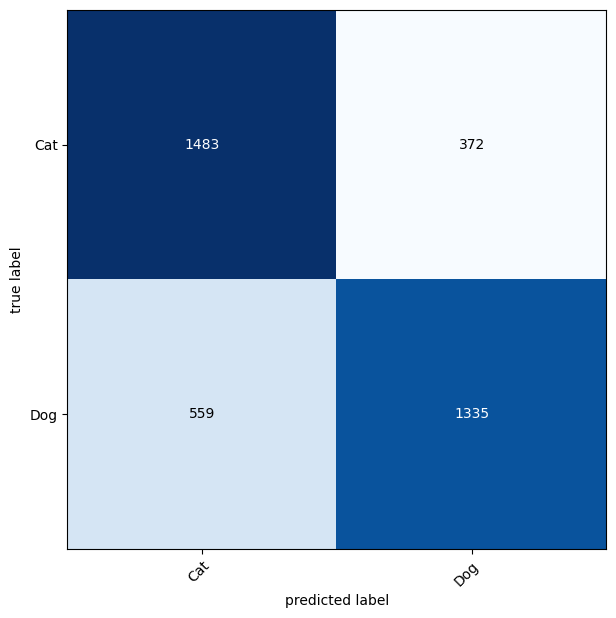

In [14]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(cls_name), task='Binary')
confmat_tensor = confmat(preds=predict_label,
                         target=true_labels)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=cls_name,
    figsize=(10, 7)
);

In [15]:
from sklearn.metrics import classification_report,roc_curve,auc

# Generate the classification report
print(classification_report(true_labels, predict_label))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1855
           1       0.78      0.70      0.74      1894

    accuracy                           0.75      3749
   macro avg       0.75      0.75      0.75      3749
weighted avg       0.75      0.75      0.75      3749



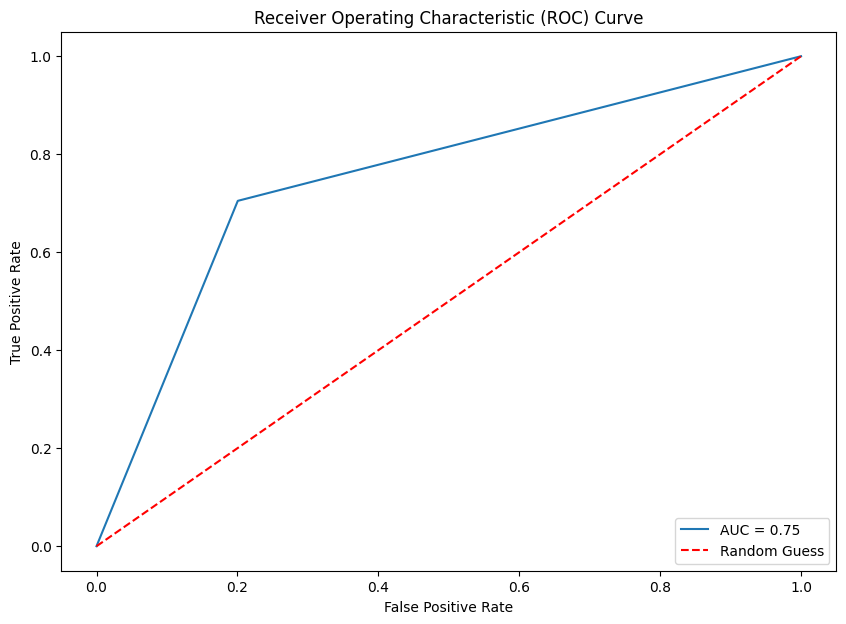

In [16]:
plt.figure(figsize=(10, 7))

fpr, tpr, _ = roc_curve(true_labels, predict_label)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')


plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()